## Installing Required Libraries

In [1]:
! pip install transformers datasets tensorflow


In [2]:
! pip install rouge-score


In [3]:
!pip install neptune

## Loading and Preprocessing the Dataset

In [4]:
import tensorflow as tf
from transformers import AutoTokenizer
from datasets import load_dataset, load_metric
import numpy as np
import random

print("Loading the BillSum dataset...")
dataset = load_dataset("billsum")
print("Dataset loaded successfully!")

import neptune

run = neptune.init_run(
    project="team19/Team19",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ZWI1ODJiNC0zZDYxLTQyMzYtOTJlMS0xNjZhYWJjMDczOWQifQ==",
)

run["dataset/name"] = "BillSum"

dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
test_valid = dataset["test"].train_test_split(test_size=0.1, seed=42)
dataset["test"] = test_valid["train"]
dataset["validation"] = test_valid["test"]

print("Dataset split into train, validation, and test sets successfully!")

print("Loading the tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
print("Tokenizer loaded successfully!")

def preprocess_function(examples):
    inputs = [doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Preprocessing the dataset...")
tokenized_dataset = dataset.map(preprocess_function, batched=True)
print("Preprocessing completed successfully!")


Loading the BillSum dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded successfully!


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/team19/Team19/e/TEAM-5
Dataset split into train, validation, and test sets successfully!
Loading the tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizer loaded successfully!
Preprocessing the dataset...
Preprocessing completed successfully!


In [5]:
def create_tf_dataset(data, batch_size=32):
    input_ids = np.array(data["input_ids"])
    attention_mask = np.array(data["attention_mask"])
    labels = np.array(data["labels"])

    dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}, labels))
    dataset = dataset.shuffle(len(input_ids)).batch(batch_size)
    return dataset
print("Creating TensorFlow Datasets...")
train_dataset = create_tf_dataset(tokenized_dataset["train"], batch_size=32)
val_dataset = create_tf_dataset(tokenized_dataset["validation"], batch_size=32)
print("TensorFlow Datasets created successfully!")

Creating TensorFlow Datasets...
TensorFlow Datasets created successfully!


Implementation of Vanilla RNNSeq2Seq Model

In [6]:
class RNNSeq2Seq(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout=0.5):
        super(RNNSeq2Seq, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.encoder = [tf.keras.layers.SimpleRNN(hidden_dim, return_sequences=True, return_state=True, dropout=dropout) for _ in range(n_layers)]
        self.decoder = [tf.keras.layers.SimpleRNN(hidden_dim, return_sequences=True, return_state=True, dropout=dropout) for _ in range(n_layers)]
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        src, trg = inputs["input_ids"], inputs["labels"]
        src_embedded = self.embedding(src)
        trg_embedded = self.embedding(trg)

        encoder_states = []
        for layer in self.encoder:
            src_embedded, state = layer(src_embedded)
            encoder_states.append(state)

        decoder_outputs = trg_embedded
        for layer, state in zip(self.decoder, encoder_states):
            decoder_outputs, _ = layer(decoder_outputs, initial_state=state)

        outputs = self.fc(decoder_outputs)
        return outputs

VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 512
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

run["model/configuration/RNN"] = {
    "vocab_size": VOCAB_SIZE,
    "embed_dim": EMBED_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_layers": N_LAYERS,
    "dropout": DROPOUT,
}

print("Initializing the RNN model...")
rnn_model = RNNSeq2Seq(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
print("Model initialized successfully!")
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print("Starting training...")
rnn_model.fit(train_dataset, validation_data=val_dataset, epochs=2)
print("Training completed successfully!")


Initializing the RNN model...
Model initialized successfully!
Starting training...
Epoch 1/2
533/533 [==============================] - 945s 2s/step - loss: 5.3394 - sparse_categorical_accuracy: 0.2510 - val_loss: 3.0365 - val_sparse_categorical_accuracy: 0.5560
Epoch 2/2
533/533 [==============================] - 920s 2s/step - loss: 2.1298 - sparse_categorical_accuracy: 0.6767 - val_loss: 1.2081 - val_sparse_categorical_accuracy: 0.8190
Training completed successfully!


In [7]:
def evaluate(model, dataset, tokenizer):
    predictions = []
    references = []
    metric = load_metric("rouge")

    for batch in dataset:
        inputs, labels = batch
        output_logits = model(inputs, training=False)
        predictions.append(tf.argmax(output_logits, axis=-1).numpy())
        references.append(labels.numpy())

    decoded_predictions = [tokenizer.decode(pred, skip_special_tokens=True) for batch in predictions for pred in batch]
    decoded_references = [tokenizer.decode(ref, skip_special_tokens=True) for batch in references for ref in batch]
    for gen_sum, ref_sum in zip(decoded_predictions, decoded_references):
        print("Generated Summary:", gen_sum)
        print("Reference Summary:", ref_sum)
        print()

    rouge_output = metric.compute(predictions=decoded_predictions, references=decoded_references)
    return rouge_output

print("Starting evaluation...")
rouge_scores_rnn = evaluate(rnn_model, val_dataset, tokenizer)
print("Evaluation completed successfully!")
print("ROUGE Scores:")
print("ROUGE-1:", rouge_scores_rnn["rouge1"].mid)
print("ROUGE-2:", rouge_scores_rnn["rouge2"].mid)
print("ROUGE-L:", rouge_scores_rnn["rougeL"].mid)

# Log ROUGE scores
run["evaluation/RNN/ROUGE-1"] = rouge_scores_rnn["rouge1"].mid.fmeasure
run["evaluation/RNN/ROUGE-2"] = rouge_scores_rnn["rouge2"].mid.fmeasure
run["evaluation/RNN/ROUGE-L"] = rouge_scores_rnn["rougeL"].mid.fmeasure

Starting evaluation...


<ipython-input-7-a77574c13e40>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Generated Summary: Requires the Director of the National Science Foundation to award grants to institutions of higher education or eligible nonprofit organizations to develop and operate spouse involved rate to interest and Centers release and high school students in science, mathematics, and technology. Spec a nonprofit organization's designated on its expertise and identified in providing the public with married science and mathematics education.

Requires grantees to enter into agreements with her high-effective local educational agencies on fails for periodically six students from schools administered by such agencies for manufacturers at such restoration. Allows the use of grant fund

## Implementing Seq2Seq Model

In [8]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout=0.5):
        super(Seq2Seq, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.encoder = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_initializer='glorot_uniform')
        self.decoder = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        src, trg = inputs["input_ids"], inputs["labels"]
        src_embedded = self.embedding(src)
        trg_embedded = self.embedding(trg)

        encoder_outputs, state_h, state_c = self.encoder(src_embedded)
        decoder_outputs, _, _ = self.decoder(trg_embedded, initial_state=[state_h, state_c])
        outputs = self.fc(decoder_outputs)
        return outputs


VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 512
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

run["model/configuration/LSTM"] = {
    "vocab_size": VOCAB_SIZE,
    "embed_dim": EMBED_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_layers": N_LAYERS,
    "dropout": DROPOUT,
}

print("Initializing the Seq2Seq model...")
seq2seq_model = Seq2Seq(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
print("Model initialized successfully!")
seq2seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
print("Starting training...")
seq2seq_model.fit(train_dataset, validation_data=val_dataset, epochs=2)
print("Training completed successfully!")


Initializing the Seq2Seq model...
Model initialized successfully!
Starting training...
Epoch 1/2
533/533 [==============================] - 232s 425ms/step - loss: 4.1428 - sparse_categorical_accuracy: 0.4380 - val_loss: 1.8849 - val_sparse_categorical_accuracy: 0.7706
Epoch 2/2
533/533 [==============================] - 220s 412ms/step - loss: 1.1764 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.9266
Training completed successfully!


In [9]:
print("Starting evaluation...")
rouge_scores_lstm = evaluate(seq2seq_model, val_dataset, tokenizer)
print("Evaluation completed successfully!")
print("ROUGE Scores:")
print("ROUGE-1:", rouge_scores_lstm["rouge1"].mid)
print("ROUGE-2:", rouge_scores_lstm["rouge2"].mid)
print("ROUGE-L:", rouge_scores_lstm["rougeL"].mid)

# Log ROUGE scores
run["evaluation/LSTM/ROUGE-1"] = rouge_scores_lstm["rouge1"].mid.fmeasure
run["evaluation/LSTM/ROUGE-2"] = rouge_scores_lstm["rouge2"].mid.fmeasure
run["evaluation/LSTM/ROUGE-L"] = rouge_scores_lstm["rougeL"].mid.fmeasure

Starting evaluation...
Generated Summary: Worker's Freedom of Choice Act - Prohibits labor commitment or employers subject to valid labor agreements from receiving, sustainabilityiting, or imp payment of choice or fees not related to exclusive representation and television purposes, including collective bargaining, contract administration, and regulating adjustment (notPD an exception under the National Labor Relations Act relating to union security agreements which require payment of union union or fees as a condition of employment). Gives a right of civil action to employees who dispute the amount so collected by labor organizations. Requires employers to post notice of such prohibition against labor behavioral using union or fees, which are collected as conditions of employment, for
Reference Summary: Worker's Freedom of Choice Act - Prohibits labor unions or employers subject to valid labor agreements from receiving, soliciting, or accepting payment of dues or fees not related to e

## Implementing GRU Model

In [10]:
# Implement GRU Model using Keras
class GRUSeq2Seq(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout=0.5):
        super(GRUSeq2Seq, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.encoder = tf.keras.layers.GRU(hidden_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_initializer='glorot_uniform')
        self.decoder = tf.keras.layers.GRU(hidden_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        src, trg = inputs["input_ids"], inputs["labels"]
        src_embedded = self.embedding(src)
        trg_embedded = self.embedding(trg)

        encoder_outputs, state = self.encoder(src_embedded)
        decoder_outputs, _ = self.decoder(trg_embedded, initial_state=state)
        outputs = self.fc(decoder_outputs)
        return outputs
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 512
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

run["model/configuration/GRU"] = {
    "vocab_size": VOCAB_SIZE,
    "embed_dim": EMBED_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_layers": N_LAYERS,
    "dropout": DROPOUT,
}

print("Initializing the GRU model...")
gru_model = GRUSeq2Seq(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
print("Model initialized successfully!")
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

print("Starting training...")
gru_model.fit(train_dataset, validation_data=val_dataset, epochs=2)
print("Training completed successfully!")

Initializing the GRU model...
Model initialized successfully!
Starting training...
Epoch 1/2
533/533 [==============================] - 223s 410ms/step - loss: 3.4904 - sparse_categorical_accuracy: 0.5623 - val_loss: 0.8232 - val_sparse_categorical_accuracy: 0.9095
Epoch 2/2
533/533 [==============================] - 209s 393ms/step - loss: 0.4216 - sparse_categorical_accuracy: 0.9551 - val_loss: 0.2057 - val_sparse_categorical_accuracy: 0.9790
Training completed successfully!


In [11]:
print("Starting evaluation...")
rouge_scores_gru = evaluate(gru_model, val_dataset, tokenizer)
print("Evaluation completed successfully!")
print("ROUGE Scores:")
print("ROUGE-1:", rouge_scores_gru["rouge1"].mid)
print("ROUGE-2:", rouge_scores_gru["rouge2"].mid)
print("ROUGE-L:", rouge_scores_gru["rougeL"].mid)

# Log ROUGE scores
run["evaluation/GRU/ROUGE-1"] = rouge_scores_gru["rouge1"].mid.fmeasure
run["evaluation/GRU/ROUGE-2"] = rouge_scores_gru["rouge2"].mid.fmeasure
run["evaluation/GRU/ROUGE-L"] = rouge_scores_gru["rougeL"].mid.fmeasure

Starting evaluation...
Generated Summary: Secure Annuity Income for Life Act of 2003 - Amends the Internal Revenue Code to exclude from gross income a percentage of lifetime annuity payments from a qualified trust to a qualified distributee. Provides for recapture and taxation of payments that are modified (other than by death or disability) so as to not qualify as lifetime annuity payments.

Applies such exclusion to: (1) section contributors(a) plans (employee annuities); (2) section contributors(b) plans (public schools and certain tax exempt organizations); (3) section amnesty plans (between retirement accounts); and (4) section
Reference Summary: Secure Annuity Income for Life Act of 2003 - Amends the Internal Revenue Code to exclude from gross income a percentage of lifetime annuity payments from a qualified trust to a qualified distributee. Provides for recapture and taxation of payments that are modified (other than by death or disability) so as to not qualify as lifetime annui

Model Comparison


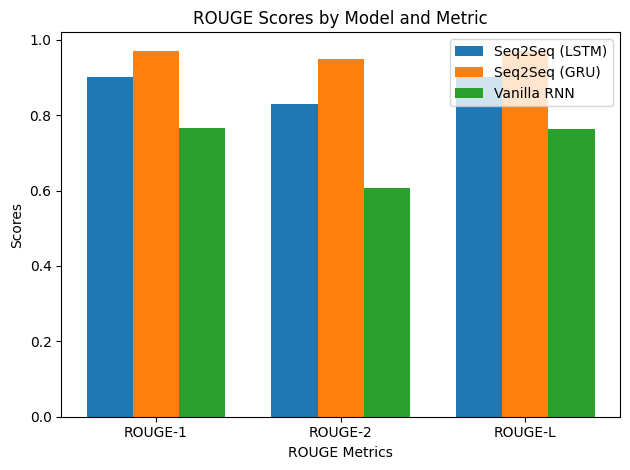

In [12]:
import matplotlib.pyplot as plt

def plot_rouge_scores(rouge_scores_lstm, rouge_scores_gru, rouge_scores_rnn):
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    lstm_scores = [rouge_scores_lstm["rouge1"].mid.fmeasure,
                   rouge_scores_lstm["rouge2"].mid.fmeasure,
                   rouge_scores_lstm["rougeL"].mid.fmeasure]

    gru_scores = [rouge_scores_gru["rouge1"].mid.fmeasure,
                  rouge_scores_gru["rouge2"].mid.fmeasure,
                  rouge_scores_gru["rougeL"].mid.fmeasure]

    rnn_scores = [rouge_scores_rnn["rouge1"].mid.fmeasure,
                          rouge_scores_rnn["rouge2"].mid.fmeasure,
                          rouge_scores_rnn["rougeL"].mid.fmeasure]

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, lstm_scores, width, label='Seq2Seq (LSTM)')
    rects2 = ax.bar(x, gru_scores, width, label='Seq2Seq (GRU)')
    rects3 = ax.bar(x + width, rnn_scores, width, label='Vanilla RNN')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('ROUGE Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('ROUGE Scores by Model and Metric')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

# Plot the ROUGE scores
plot_rouge_scores(rouge_scores_lstm, rouge_scores_gru, rouge_scores_rnn)
